## Семинар 2 "Распознавание рукописных цифр"

ФИО: Личманов Дмитрий Игоревич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
!pip install torchvision

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

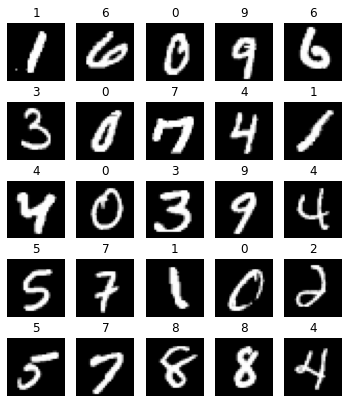

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [6]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [7]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.311/0.308	Accuracy: 0.918/0.916

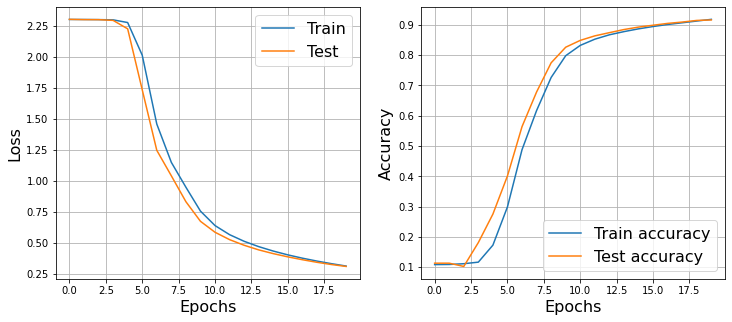

In [8]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [9]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [10]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [11]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.037/0.083	Accuracy: 0.990/0.976

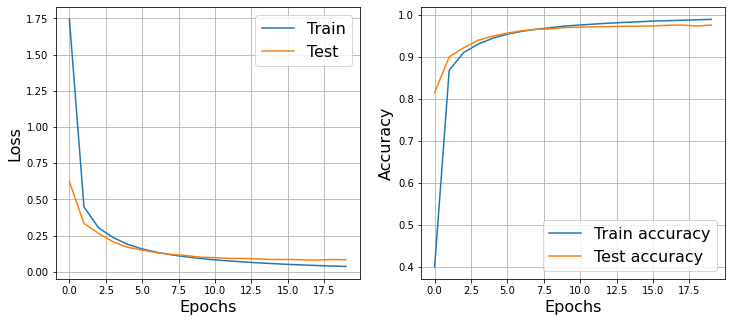

In [12]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.044/0.079	Accuracy: 0.987/0.974

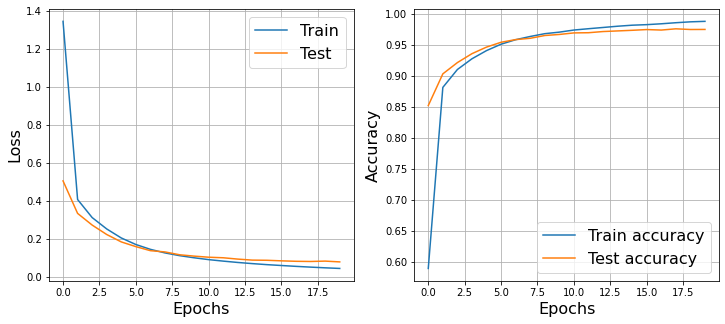

In [13]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

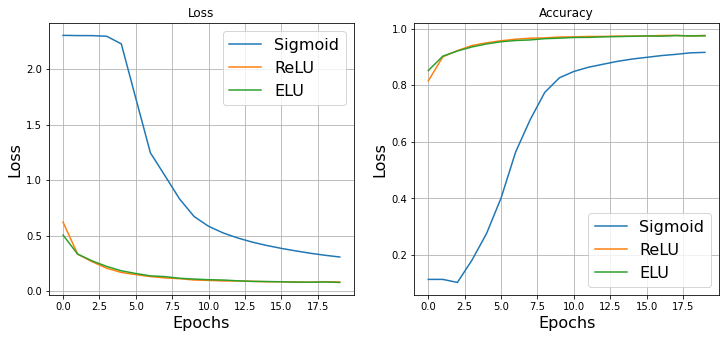

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [15]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.tanh = np.tanh(X)
        return self.tanh

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (1 - self.tanh**2) * dLdy

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.028/0.078	Accuracy: 0.994/0.976

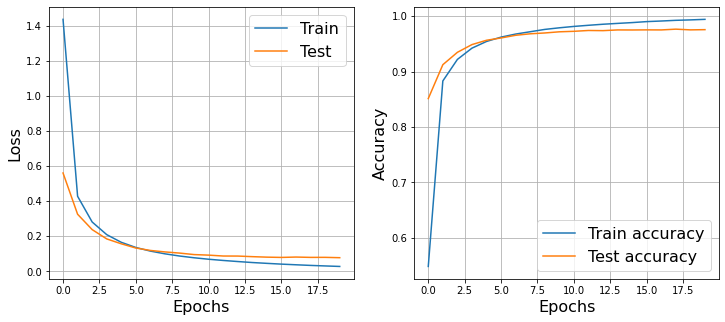

In [16]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

### Часть 3: Анализ ошибок

In [17]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

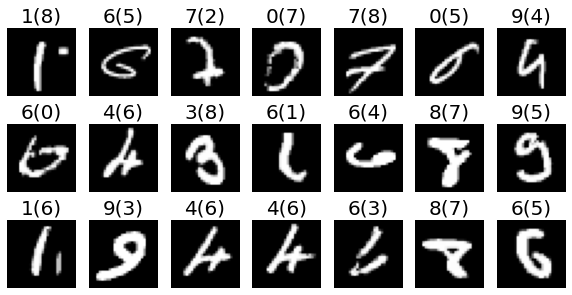

In [18]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [19]:
!pip install scikit-image

In [20]:
from skimage.transform import rotate

#### Небольшие вращения (-15, 15)



In [36]:
basic_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [37]:
transform = transforms.Compose([
                       transforms.RandomAffine(degrees=15),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

basic_dataset = MNIST('.', train=True, transform=basic_transform)
train_dataset = MNIST('.', train=True, download=True, transform=transform)
train_dataset = train_dataset + basic_dataset
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [38]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()


Epoch 19... (Train/Test) NLL: 0.159/0.182	Accuracy: 0.956/0.947

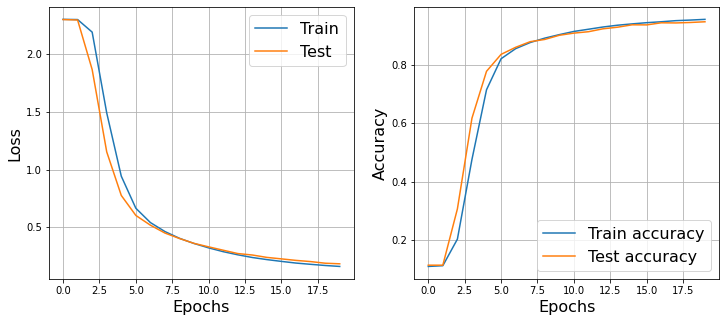

In [39]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()
rot_tr_e, rot_ts_e, rot_tr_ac_e, rot_ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

#### Случайные сдвиги

In [40]:
transform = transforms.Compose([
                       transforms.RandomAffine(degrees=0, translate=(0.1,0.1)), #in percent
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

basic_dataset = MNIST('.', train=True, transform=basic_transform)
train_dataset = MNIST('.', train=True, download=True, transform=transform)
train_dataset = train_dataset + basic_dataset
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [41]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()


Epoch 19... (Train/Test) NLL: 0.221/0.285	Accuracy: 0.938/0.918

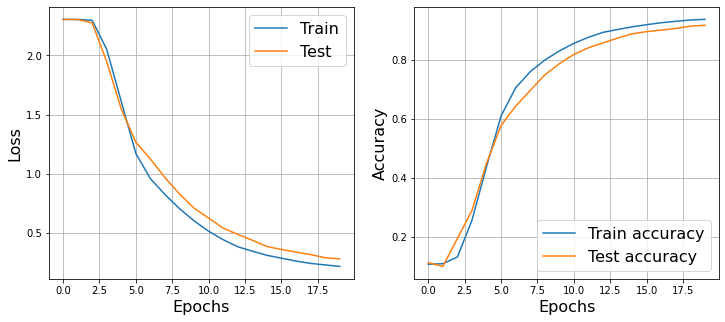

In [42]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()
trans_tr_e, trans_ts_e, trans_tr_ac_e, trans_ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)


In [43]:
import torch

#### Шум

In [44]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: x + torch.randn_like(x)),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

basic_dataset = MNIST('.', train=True, transform=basic_transform)
train_dataset = MNIST('.', train=True, download=True, transform=transform)
train_dataset = train_dataset + basic_dataset
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [45]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()


Epoch 19... (Train/Test) NLL: 0.448/0.672	Accuracy: 0.858/0.782

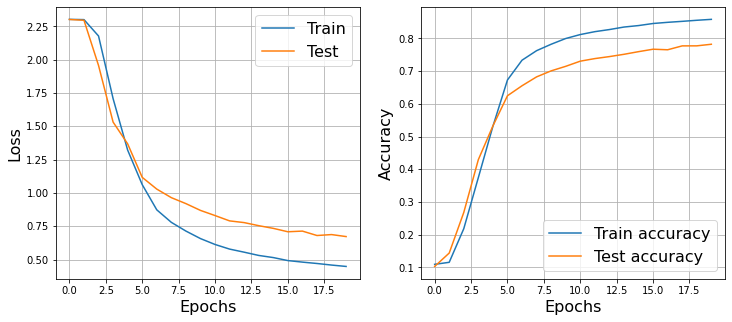

In [46]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()
rand_tr_e, rand_ts_e, rand_tr_ac_e, rand_ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

#### Комбинированные аугментации

In [50]:
transform = transforms.Compose([
                       transforms.RandomAffine(degrees=15, translate=(0.1,0.1)),
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: x + torch.randn_like(x)),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

basic_dataset = MNIST('.', train=True, transform=basic_transform)
train_dataset = MNIST('.', train=True, download=True, transform=transform)
train_dataset = train_dataset + basic_dataset
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [51]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()


Epoch 19... (Train/Test) NLL: 0.803/1.325	Accuracy: 0.744/0.552

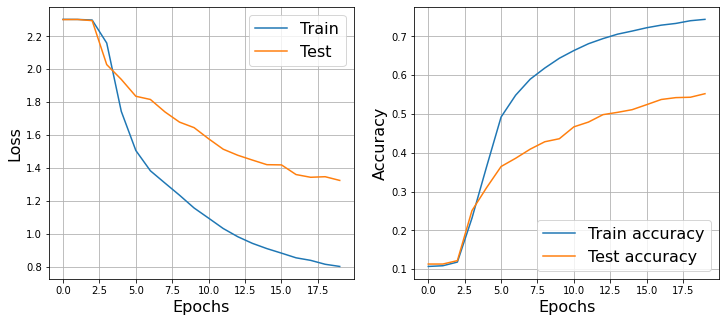

In [52]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()
all_tr_e, all_ts_e, all_tr_ac_e, all_ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)



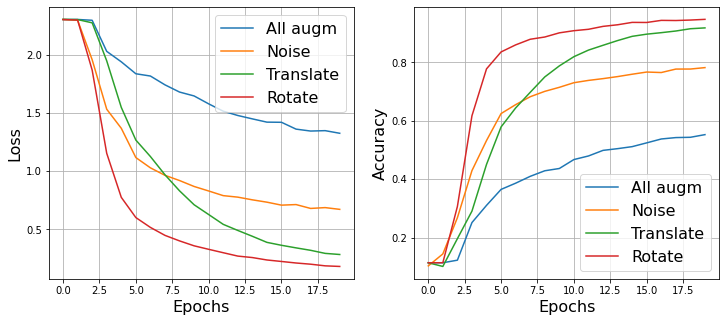

In [53]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(all_ts_e, label='All augm')
plt.plot(rand_ts_e, label='Noise')
plt.plot(trans_ts_e, label='Translate')
plt.plot(rot_ts_e, label='Rotate')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(all_ts_ac_e, label='All augm')
plt.plot(rand_ts_ac_e, label='Noise')
plt.plot(trans_ts_ac_e, label='Translate')
plt.plot(rot_ts_ac_e, label='Rotate')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()


Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.
(буду обучать c аугментацией с лучшим показателем accuracy - rotate)

In [57]:
transform = transforms.Compose([
                       transforms.RandomAffine(degrees=15),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

basic_dataset = MNIST('.', train=True, transform=basic_transform)
train_dataset = MNIST('.', train=True, download=True, transform=transform)
train_dataset = train_dataset + basic_dataset
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [58]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()


Epoch 19... (Train/Test) NLL: 0.037/0.077	Accuracy: 0.989/0.977

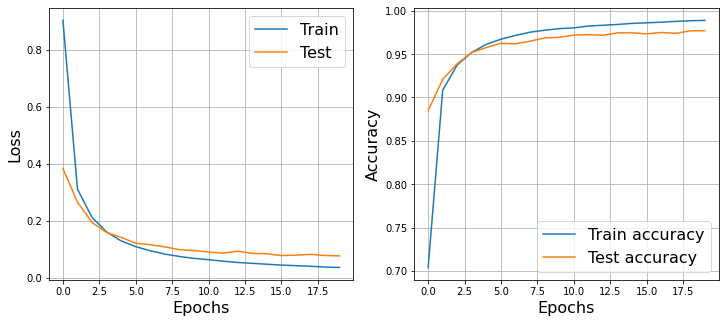

In [59]:
network = NeuralNetwork([
    Linear(784, 100), ELU(), # 28 * 28
    Linear(100, 100), ELU(),
    Linear(100, 10)
])
loss = NLLLoss()
rot_tr_e, rot_ts_e, rot_tr_ac_e, rot_ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)


In [60]:
transform = transforms.Compose([
                       transforms.RandomAffine(degrees=15),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

basic_dataset = MNIST('.', train=True, transform=basic_transform)
train_dataset = MNIST('.', train=True, download=True, transform=transform)
train_dataset = train_dataset + basic_dataset
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [61]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()


Epoch 19... (Train/Test) NLL: 0.033/0.076	Accuracy: 0.990/0.977

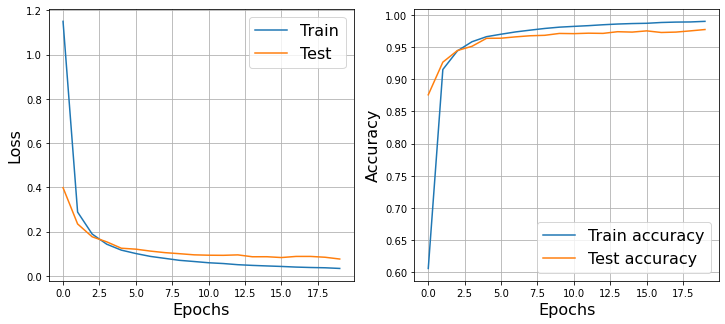

In [62]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(), # 28 * 28
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
rot_tr_e_lr, rot_ts_e_lr, rot_tr_ac_e_lr, rot_ts_ac_e_lr = train(network, 20, 0.01, plot=True, verbose=True)

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Сами по себе агументации не показали себя. Однако совмещенный train_dataset на rotate работает весьма хорошо. Нелинейности ReLU и ELU показали точность лучше Sigmoid, как на аугментации, так и без нее